<a href="https://colab.research.google.com/github/SzymonNowakowski/Machine-Learning-2024/blob/master/Lab13-towards-self-attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab 13 - Towards Self-Attention (*pl. Samoatencja*)


### Author: Szymon Nowakowski


# Introduction
---------------

In this class, we build on our understanding of attention by introducing **self-attention**—a powerful mechanism that allows each word in a sentence to attend to **every other word**, including itself. While basic attention required an external query (e.g., from a classifier or decoder), self-attention uses the words within a sequence to compute their mutual influence, enabling the model to capture dependencies regardless of distance or position.

This mechanism lies at the heart of modern architectures like the Transformer. By the end of this class, you’ll understand how self-attention works, how it differs from earlier forms of attention, and why it enables models to process sequences in parallel while preserving word-to-word relationships.

In our next class, we’ll combine self-attention with other components—like feedforward layers and residual connections—to build the full Transformer architecture.




## Acknowledgments

*I would like to express my gratitude to my colleague **Przemysław Olbratowski** for this elegant way of introducing attention, which I find both intuitive and pedagogically effective.*

# Yelp Reviews Polarity Dataset  
--------------

We shall continue to work with **Yelp Reviews Polarity Dataset**.

This dataset contains **over 560k full-text reviews** from Yelp, labeled for **binary sentiment**:  
- **positive** (5-star reviews)  
- **negative** (1-star reviews)  

We will not use the full dataset, because it cannot be handled by Colab RAM.

Each example is a **real user-generated review**, typically 2–5 sentences long, capturing clear and direct sentiment in natural language.  
There are no ambiguous or neutral labels, making this dataset ideal for training and evaluating **binary sentiment classifiers**.

The dataset was curated and released as part of the **FastText** and **Text Classification Benchmarks** by researchers at Facebook AI. It is widely used for benchmarking sentiment models in both academia and industry.


In [ ]:
!pip install datasets

In [ ]:
from datasets import load_dataset
import collections
import re                             # Regular Expressions: for text searching and cleaning

MAX_LEN = 128

# Load Yelp Polarity dataset from Hugging Face (one-time use)
raw = load_dataset("yelp_polarity")

N_TRAIN = 100_000
N_TEST = 20_000   # VAL + TEST sets

train_raw = raw["train"].shuffle(seed=42).select(range(N_TRAIN))
test_raw  = raw["test"].shuffle(seed=42).select(range(N_TEST))


# Extract plain Python lists for text and labels
def to_lists(dataset):
    texts = []
    labels = []
    for example in dataset:
        texts.append(example["text"])
        labels.append(example["label"])
    return texts, labels

train_texts, train_labels = to_lists(train_raw)
test_texts, test_labels   = to_lists(test_raw)

# Split test set into val/test
from sklearn.model_selection import train_test_split
val_texts, test_texts, val_labels, test_labels = train_test_split(
    test_texts, test_labels, test_size=0.5, random_state=42
)

# Show class counts
def print_distribution(name, labels):
    c = collections.Counter(labels)
    total = sum(c.values())
    print(f"\n{name} distribution:")
    for label in sorted(c.keys()):
        print(f"  {label}: {c[label]} ({c[label]/total:.2%})")

print_distribution("Train", train_labels)
print_distribution("Validation", val_labels)
print_distribution("Test", test_labels)

label_map = {0: "negative", 1: "positive"}



Train distribution:
  0: 50209 (50.21%)
  1: 49791 (49.79%)

Validation distribution:
  0: 5038 (50.38%)
  1: 4962 (49.62%)

Test distribution:
  0: 4973 (49.73%)
  1: 5027 (50.27%)


# Adding Artificial (Concatenated) Sentences
-----------------

Working with the same dataset provides a practical benchmark: we can now assess whether using more sophisticated attention mechanisms (such as self-attention) leads to measurable improvements over simpler approaches like mean-pooling or fixed attention.

**To recap:**

In this augmentation strategy, each original sentence is placed at the end of a newly formed input, preceded by a randomly chosen distractor sentence. The original label is retained, ensuring that every new example remains correctly annotated. This approach doubles the dataset size (token-wise) while preserving both the number of samples and the overall label distribution.

The task now becomes more focused: the model must learn to attend to the main sentence and ignore the irrelevant prefix.

- **With attention**: the model can assign higher weights to the meaningful part of the input and suppress noise, including any trailing `<PAD>` tokens.
- **Without attention**: a mean-pooling model processes all tokens equally, making it harder to isolate the signal from the noise introduced by the distractor.

In [ ]:
import random

MAX_LEN = 256  # changing max len to accomodate longer sequences, also, longer sequences are harder for the mean network

def pair_every_sentence_with_random(texts, labels, seed=42):
    """
    For each sentence, append a randomly selected second sentence.
    The label of the first is preserved.
    """
    random.seed(seed)
    n = len(texts)

    augmented_texts = []
    augmented_labels = []

    for i in range(n):
        first = texts[i]
        label = labels[i]

        second = texts[random.randint(0, n - 1)]

        combined = second + " " + first # we prepend the sentence with a random one, now

        augmented_texts.append(combined)
        augmented_labels.append(label)

    return texts + augmented_texts, labels + augmented_labels


train_texts, train_labels = pair_every_sentence_with_random(train_texts, train_labels)
val_texts, val_labels     = pair_every_sentence_with_random(val_texts,   val_labels)
test_texts, test_labels   = pair_every_sentence_with_random(test_texts,  test_labels)

# Reprocess splits into padded input_ids
train_ids = process_texts(train_texts, vocab, MAX_LEN)
val_ids   = process_texts(val_texts, vocab, MAX_LEN)
test_ids  = process_texts(test_texts, vocab, MAX_LEN)

# Recalculate data loaders
train_loader = to_loader(train_ids, train_labels, BATCH_SIZE, shuffle=True)
val_loader   = to_loader(val_ids, val_labels, BATCH_SIZE)
test_loader  = to_loader(test_ids, test_labels, BATCH_SIZE)


# Tokenizer
-------------------

We shall also reuse the same tokenizer.

In [ ]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r'<[^>]+>', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text.split()

def build_vocab(token_lists, min_freq=2):
    counter = collections.Counter(token for tokens in token_lists for token in tokens)
    vocab = {
        token: idx + 2  # reserve 0: <PAD>, 1: <UNK>
        for idx, (token, count) in enumerate(counter.items())
        if count >= min_freq
    }
    vocab['<PAD>'] = 0
    vocab['<UNK>'] = 1
    return vocab

def tokens_to_ids(tokens, vocab):
    return [vocab.get(tok, vocab['<UNK>']) for tok in tokens]   #for unknown tokens return vocab['<UNK>'] (which is == 1)

def pad(seq, max_len=128, pad_value=0):
    return seq + [pad_value] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len]

def process_texts(texts, vocab, max_len=128):
    return [pad(tokens_to_ids(tokenize(text), vocab), max_len) for text in texts]


# Tokenize training set and build vocab
train_tokens = [tokenize(t) for t in train_texts]
vocab = build_vocab(train_tokens)

# Process splits into padded input_ids
train_ids = process_texts(train_texts, vocab, MAX_LEN)
val_ids   = process_texts(val_texts, vocab, MAX_LEN)
test_ids  = process_texts(test_texts, vocab, MAX_LEN)

# Print 5 real examples: raw text, tokenized, and input IDs
shown = 0
for i in range(len(train_texts)):
    if 1 in train_ids[i][:5]:  # 1 is <UNK>
        print(f"Original:   {train_texts[i]}")
        print(f"Tokenized:  {train_tokens[i]}")
        print(f"Input IDs:  {train_ids[i]}\n")
        shown += 1
        if shown >= 5:
            break





Original:   I've been to Benihannas several times in a California and Arizona. I must say that there isn't any consistency with this place. The one here in chandler is not very good. I think they are surviving off of the reputation not customer service. First the girl working as the hostess needs to learn how to smile and actually act like she likes her job. Word of advice for her. If you can't smile, be cordial, have a personality then quit and find another line of work but obviously interacting with the public is not your calling. \n\nVery long wait to eat.... The servers are slow and you have to wait forever just to get drinks and refills...\n\nI think for $100 I can spend it elsewhere and get better service and food...
Tokenized:  ['i', 've', 'been', 'to', 'benihannas', 'several', 'times', 'in', 'a', 'california', 'and', 'arizona', 'i', 'must', 'say', 'that', 'there', 'isn', 't', 'any', 'consistency', 'with', 'this', 'place', 'the', 'one', 'here', 'in', 'chandler', 'is', 'not', 've

# Data Loaders, Training Loop and Plotting
--------------------

We reuse those as well.

## Data Loaders

In [ ]:
import torch

BATCH_SIZE = 1024

torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)

# Convert all to tensors
def to_loader(input_ids, labels, batch_size=1024, shuffle=False):
    x_tensor = torch.tensor(input_ids, dtype=torch.long)
    y_tensor = torch.tensor(labels, dtype=torch.long)
    return torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_tensor, y_tensor), batch_size=batch_size, shuffle=shuffle)

train_loader = to_loader(train_ids, train_labels, BATCH_SIZE, shuffle=True)
val_loader   = to_loader(val_ids, val_labels, BATCH_SIZE)
test_loader  = to_loader(test_ids, test_labels, BATCH_SIZE)


## Train Loop Function

In [ ]:
import time
import torch
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Working on {device}")

def train_model(net, train_loader, val_loader, epochs=1000, lr=0.001, log_every=10):
    print(f"Working on {device}")
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()

    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    start_time = time.time()

    for epoch in range(epochs):
        net.train()
        train_loss_sum = 0.0
        train_correct = 0
        train_total = 0

        for batch_inputs, batch_labels in train_loader:
            batch_inputs = batch_inputs.to(device)
            batch_labels = batch_labels.to(device).float()  # shape: (batch_size)

            optimizer.zero_grad()
            logits = net(batch_inputs)  # logits shape: (batch_size, 1)
            loss = criterion(logits, batch_labels)
            loss.backward()
            optimizer.step()

            train_loss_sum += loss.item() * batch_inputs.size(0)
            preds = (torch.sigmoid(logits) > 0.5).float()
            train_correct += (preds == batch_labels).sum().item()
            train_total += batch_inputs.size(0)

        avg_train_loss = train_loss_sum / train_total
        train_acc = train_correct / train_total
        train_loss_history.append(avg_train_loss)
        train_acc_history.append(train_acc)

        # === Validation ===
        net.eval()
        val_loss_sum = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for batch_inputs, batch_labels in val_loader:
                batch_inputs = batch_inputs.to(device)
                batch_labels = batch_labels.to(device).float()

                logits = net(batch_inputs)
                loss = criterion(logits, batch_labels)

                val_loss_sum += loss.item() * batch_inputs.size(0)
                preds = (torch.sigmoid(logits) > 0.5).float()
                val_correct += (preds == batch_labels).sum().item()
                val_total += batch_inputs.size(0)

        avg_val_loss = val_loss_sum / val_total
        val_acc = val_correct / val_total
        val_loss_history.append(avg_val_loss)
        val_acc_history.append(val_acc)

        if epoch % log_every == 0:
            print(f"Epoch {epoch:03d} | "
                  f"Train Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} | "
                  f"Val Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f}")

    end_time = time.time()
    print(f"Elapsed time: {end_time - start_time:.2f} seconds")

    return train_loss_history, val_loss_history, train_acc_history, val_acc_history

Working on cpu


## Plot Function

In [ ]:
import matplotlib.pyplot as plt

def plot_training_curves(train_loss, val_loss, train_acc, val_acc):
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    # Plot Loss
    axs[0].plot(train_loss, label="Train Loss", color='blue')
    axs[0].plot(val_loss, label="Val Loss", color='orange')
    axs[0].set_title("Loss per Epoch")
    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Average Loss")
    axs[0].grid(True)
    axs[0].legend()

    # Plot Accuracy
    axs[1].plot(train_acc, label="Train Accuracy", color='green')
    axs[1].plot(val_acc, label="Val Accuracy", color='red')
    axs[1].set_title("Accuracy per Epoch")
    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].grid(True)
    axs[1].legend()

    plt.tight_layout()
    plt.show()

In [ ]:
import random

MAX_LEN = 256  # changing max len to accomodate longer sequences, also, longer sequences are harder for the mean network

def pair_every_sentence_with_random(texts, labels, seed=42):
    """
    For each sentence, append a randomly selected second sentence.
    The label of the first is preserved.
    """
    random.seed(seed)
    n = len(texts)

    augmented_texts = []
    augmented_labels = []

    for i in range(n):
        first = texts[i]
        label = labels[i]

        second = texts[random.randint(0, n - 1)]

        combined = second + " " + first # we prepend the sentence with a random one, now

        augmented_texts.append(combined)
        augmented_labels.append(label)

    return texts + augmented_texts, labels + augmented_labels


train_texts, train_labels = pair_every_sentence_with_random(train_texts, train_labels)
val_texts, val_labels     = pair_every_sentence_with_random(val_texts,   val_labels)
test_texts, test_labels   = pair_every_sentence_with_random(test_texts,  test_labels)

# Reprocess splits into padded input_ids
train_ids = process_texts(train_texts, vocab, MAX_LEN)
val_ids   = process_texts(val_texts, vocab, MAX_LEN)
test_ids  = process_texts(test_texts, vocab, MAX_LEN)

# Recalculate data loaders
train_loader = to_loader(train_ids, train_labels, BATCH_SIZE, shuffle=True)
val_loader   = to_loader(val_ids, val_labels, BATCH_SIZE)
test_loader  = to_loader(test_ids, test_labels, BATCH_SIZE)


# Positional Encoding
-----------------------

We shall also reuse positional encoding.

In [ ]:
import torch

pos_cnt = 16
positional_encoding_B = 1000

def sinusoid_positions(max_len = MAX_LEN, dim = pos_cnt):
    pos = torch.arange(max_len, device=device).float().unsqueeze(1)
    i   = torch.arange(dim, device=device).float().unsqueeze(0)
    angle = pos / (positional_encoding_B ** (2 * (i//2) / dim))
    S = torch.zeros(max_len, dim, device=device)
    S[:, 0::2] = torch.sin(angle[:, 0::2])
    S[:, 1::2] = torch.cos(angle[:, 1::2])
    return S          #  SIZE: words, features  (constant matrix throuoght all computations)



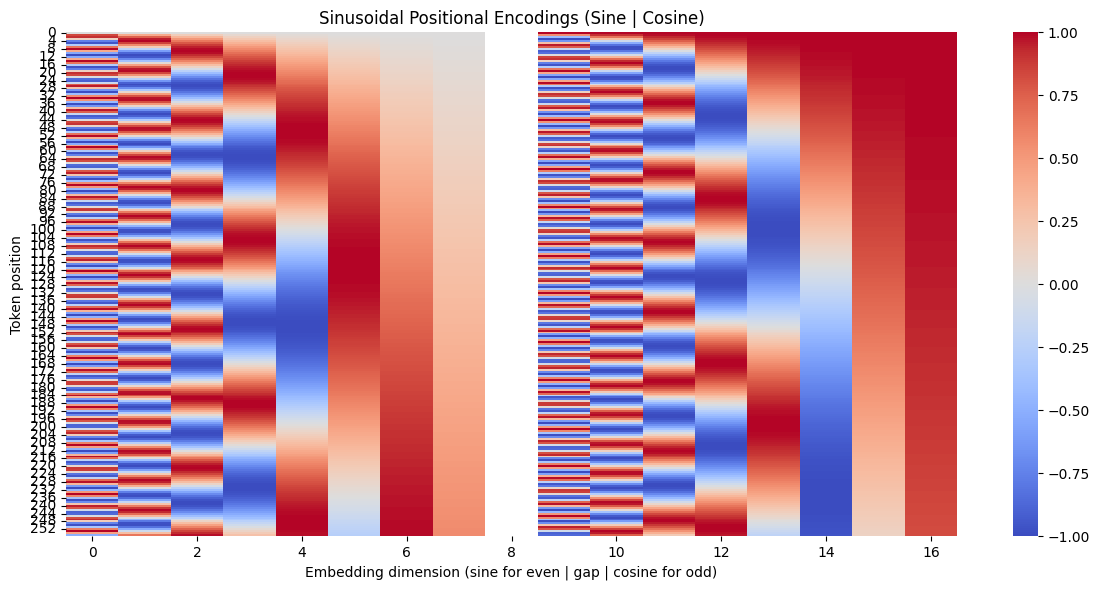

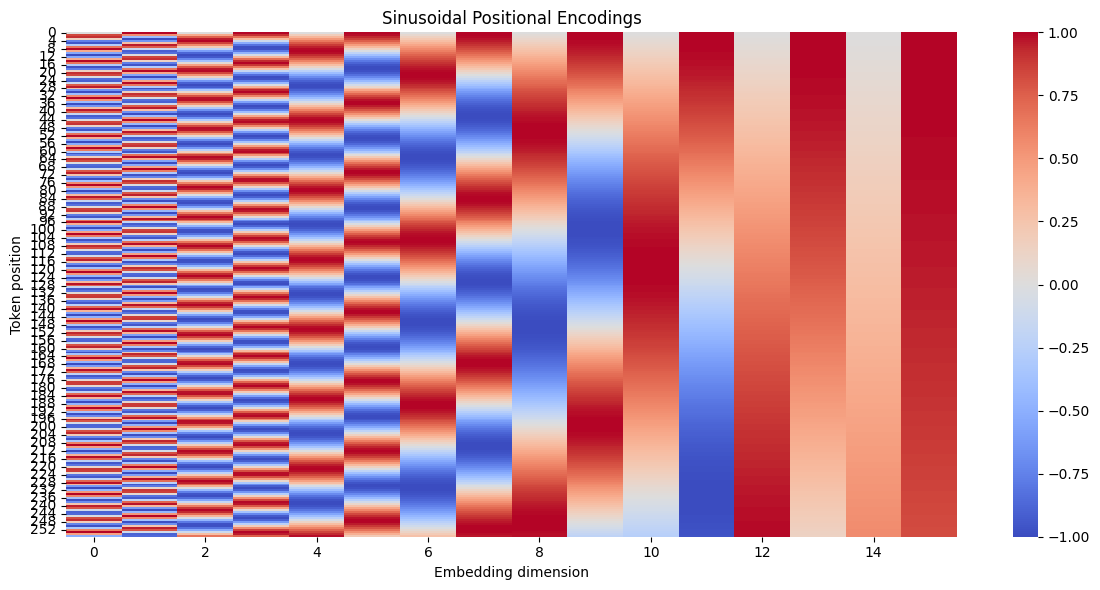

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create sinusoidal matrix S
S = sinusoid_positions() # size: words, features

# Separate sine (even) and cosine (odd) components
sine = S[:, ::2]
cosine = S[:, 1::2]
gap = torch.full((S.size(0), 1), float('nan'))  # vertical separator

# Concatenate: [sine | gap | cosine]
S_sep = torch.cat([sine, gap, cosine], dim=1)

# Plot as heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(S_sep.cpu().numpy(), cmap="coolwarm", cbar=True, xticklabels=2, yticklabels=4)
plt.title("Sinusoidal Positional Encodings (Sine | Cosine)")
plt.xlabel("Embedding dimension (sine for even | gap | cosine for odd)")
plt.ylabel("Token position")
plt.tight_layout()
plt.show()

# Plot as heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(S.cpu().numpy(), cmap="coolwarm", cbar=True, xticklabels=2, yticklabels=4)
plt.title("Sinusoidal Positional Encodings")
plt.xlabel("Embedding dimension")
plt.ylabel("Token position")
plt.tight_layout()
plt.show()



# Recall the Attention Network
-----------------------

Working on cpu
Epoch 000 | Train Loss: 0.6946, Acc: 0.5328 | Val Loss: 0.6819, Acc: 0.5667
Epoch 010 | Train Loss: 0.3689, Acc: 0.8424 | Val Loss: 0.3885, Acc: 0.8348
Elapsed time: 389.25 seconds


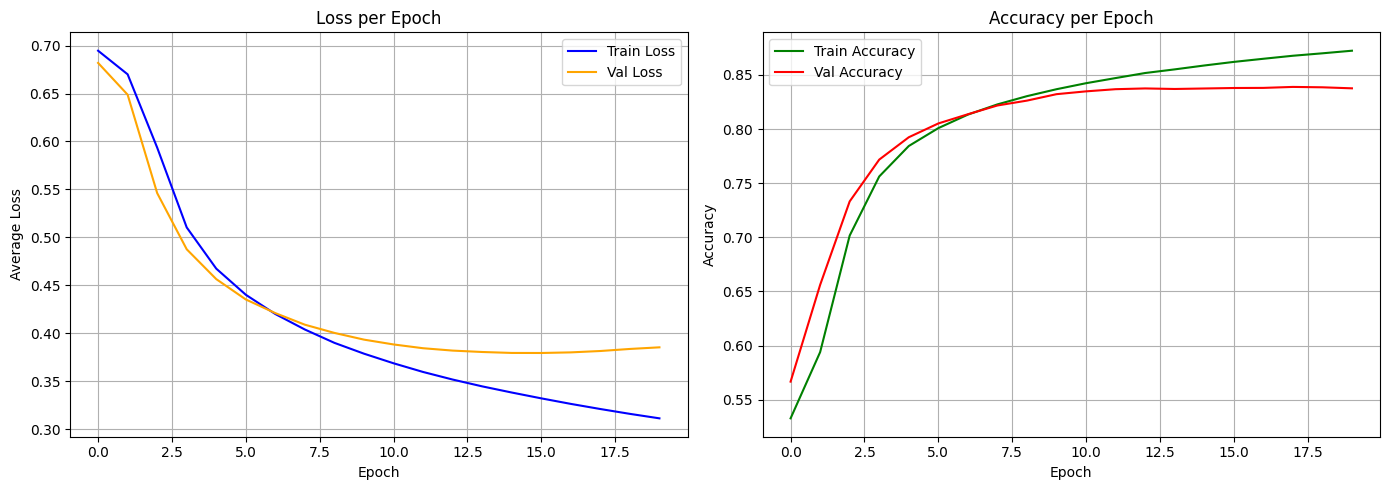

In [ ]:
embed_cnt = 16          # word embeddings
pos_cnt = 16            # pos embeddings
feature_cnt = 16

vocab_len = max(vocab.values()) + 1   # maximal value (index) of a token

class Attention(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.energy = torch.nn.Linear(feature_cnt, 1)
    def forward(self, features):                        #SIZE: batch, words, features
        batch = features.size(0)          # get the batch dimension
        words = features.size(1)          # get the words dimension
        energies = self.energy(features)                #SIZE: batch, words, 1
        energies = energies.transpose(-2, -1)           #SIZE: batch, 1, words
        weights = F.softmax(energies, -1)               #SIZE: batch, 1, words
        features = weights @ features                   #SIZE: batch, 1, features
        return features

class Net_Attention_And_PE(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = torch.nn.Embedding(vocab_len, embed_cnt)
        self.attention = Attention()
        self.classifier = torch.nn.Linear(feature_cnt, 1)
    def forward(self, index):                            #SIZE: batch, words
        features = self.embedding(index) + S             #SIZE: batch, words, features

        ### This is where WHEIGHTED AVERAGING with LEARNED WEIGHTS takes place
        features = self.attention(features)              #SIZE: batch, 1, features

        classifications = self.classifier(features)      #SIZE: batch, 1, 1
        logits = classifications.squeeze(-1).squeeze(-1) #SIZE: batch
        return logits

net_att_pe = Net_Attention_And_PE()

# Execute training again
train_loss, val_loss, train_acc, val_acc = train_model(net_att_pe, train_loader, val_loader, epochs = 20)
plot_training_curves(train_loss, val_loss, train_acc, val_acc)

# Towards Self-Attention!
--------------------